Студент: Ахметова Алия Айдаровна

Телеграмм: https://t.me/alialiyusha

# Задача матчинга

Дано множество товаров. Каждый товар (объект) в множестве описывается какими-то признаками. Для каждого объекта из некоторго множества найти один или несколько объектов из другого множетсва, которые близки к нему по некоторой заданной метрике.

Имеем следующие исходные данные:
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;
- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов);
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv;
- validation_answer.csv - правильные ответы к предыдущему файлу.

# Задачи проекта:
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.




# Подготовка данных

### Загрузка необходимых библиотек

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Не получается загрузить библиотеку FAISS, пробывала двумя способами (работаю в kaggle).
</div>

In [9]:
#!pip install faiss-cpu -q
!pip install faiss-cpu -q

ERROR: Could not find a version that satisfies the requirement faiss-cpu (from versions: none)
ERROR: No matching distribution found for faiss-cpu


Попытка загрузки faiss.

In [10]:
req = """faiss-cpu
"""

!echo {repr(req)} > requirements.txt
!cat ./requirements.txt

faiss-cpu\n


In [11]:
!mkdir dep
%cd dep
!pip download -r ../requirements.txt

/kaggle/working/dep/dep
ERROR: Invalid requirement: 'faiss-cpu\\n' (from line 1 of ../requirements.txt)


### Импорт всего

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.preprocessing import StandardScaler

# KMeans + NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
# FAISS
#import faiss


Загрузим данные из файлов:

In [13]:
%%time
data_base = pd.read_csv('/kaggle/input/masterskaya-2/base.csv', index_col=0)
data_train = pd.read_csv('/kaggle/input/masterskaya-2/train.csv', index_col=0)
data_valid = pd.read_csv('/kaggle/input/masterskaya-2/validation.csv', index_col=0)
data_answer = pd.read_csv('/kaggle/input/masterskaya-2/validation_answer.csv', index_col=0)

CPU times: user 31.4 s, sys: 3.61 s, total: 35 s
Wall time: 52.4 s


Выведем несколько строк из каждого датасета.

In [14]:
for data in (data_base, data_train, data_valid, data_answer):
    display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Приведем названия колонок к нижнему регистру.

In [15]:
for data in (data_base, data_train, data_valid, data_answer):
    data.columns = data.columns.str.lower()

### Предварительный анализ данных

Рассмотрим наши данные более подробно. 

#### Датасет **base**

Проверим наличие пропусков, дубликатов, выведем основную информацию и построим графики распределения значений в колонках.

In [16]:
def info_about_datas(data):
    print('Количество пропусков:')
    display(data.isna().sum())
    
    print('Кол-во товаров-дубликатов:', data.duplicated().sum())
    
    display(data.info(verbose=True, show_counts=True))
    display(data.describe())
    
    print('Распределение значений в колонках:')
    data.hist(figsize=(26,22)) 
    plt.show()

Количество пропусков:


0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Кол-во товаров-дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float64
 1   1       2918139 non-null  float64
 2   2       2918139 non-null  float64
 3   3       2918139 non-null  float64
 4   4       2918139 non-null  float64
 5   5       2918139 non-null  float64
 6   6       2918139 non-null  float64
 7   7       2918139 non-null  float64
 8   8       2918139 non-null  float64
 9   9       2918139 non-null  float64
 10  10      2918139 non-null  float64
 11  11      2918139 non-null  float64
 12  12      2918139 non-null  float64
 13  13      2918139 non-null  float64
 14  14      2918139 non-null  float64
 15  15      2918139 non-null  float64
 16  16      2918139 non-null  float64
 17  17      2918139 non-null  float64
 18  18      2918139 non-null  float64
 19  19      2918139 non-null  flo

None

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


Распределение значений в колонках:


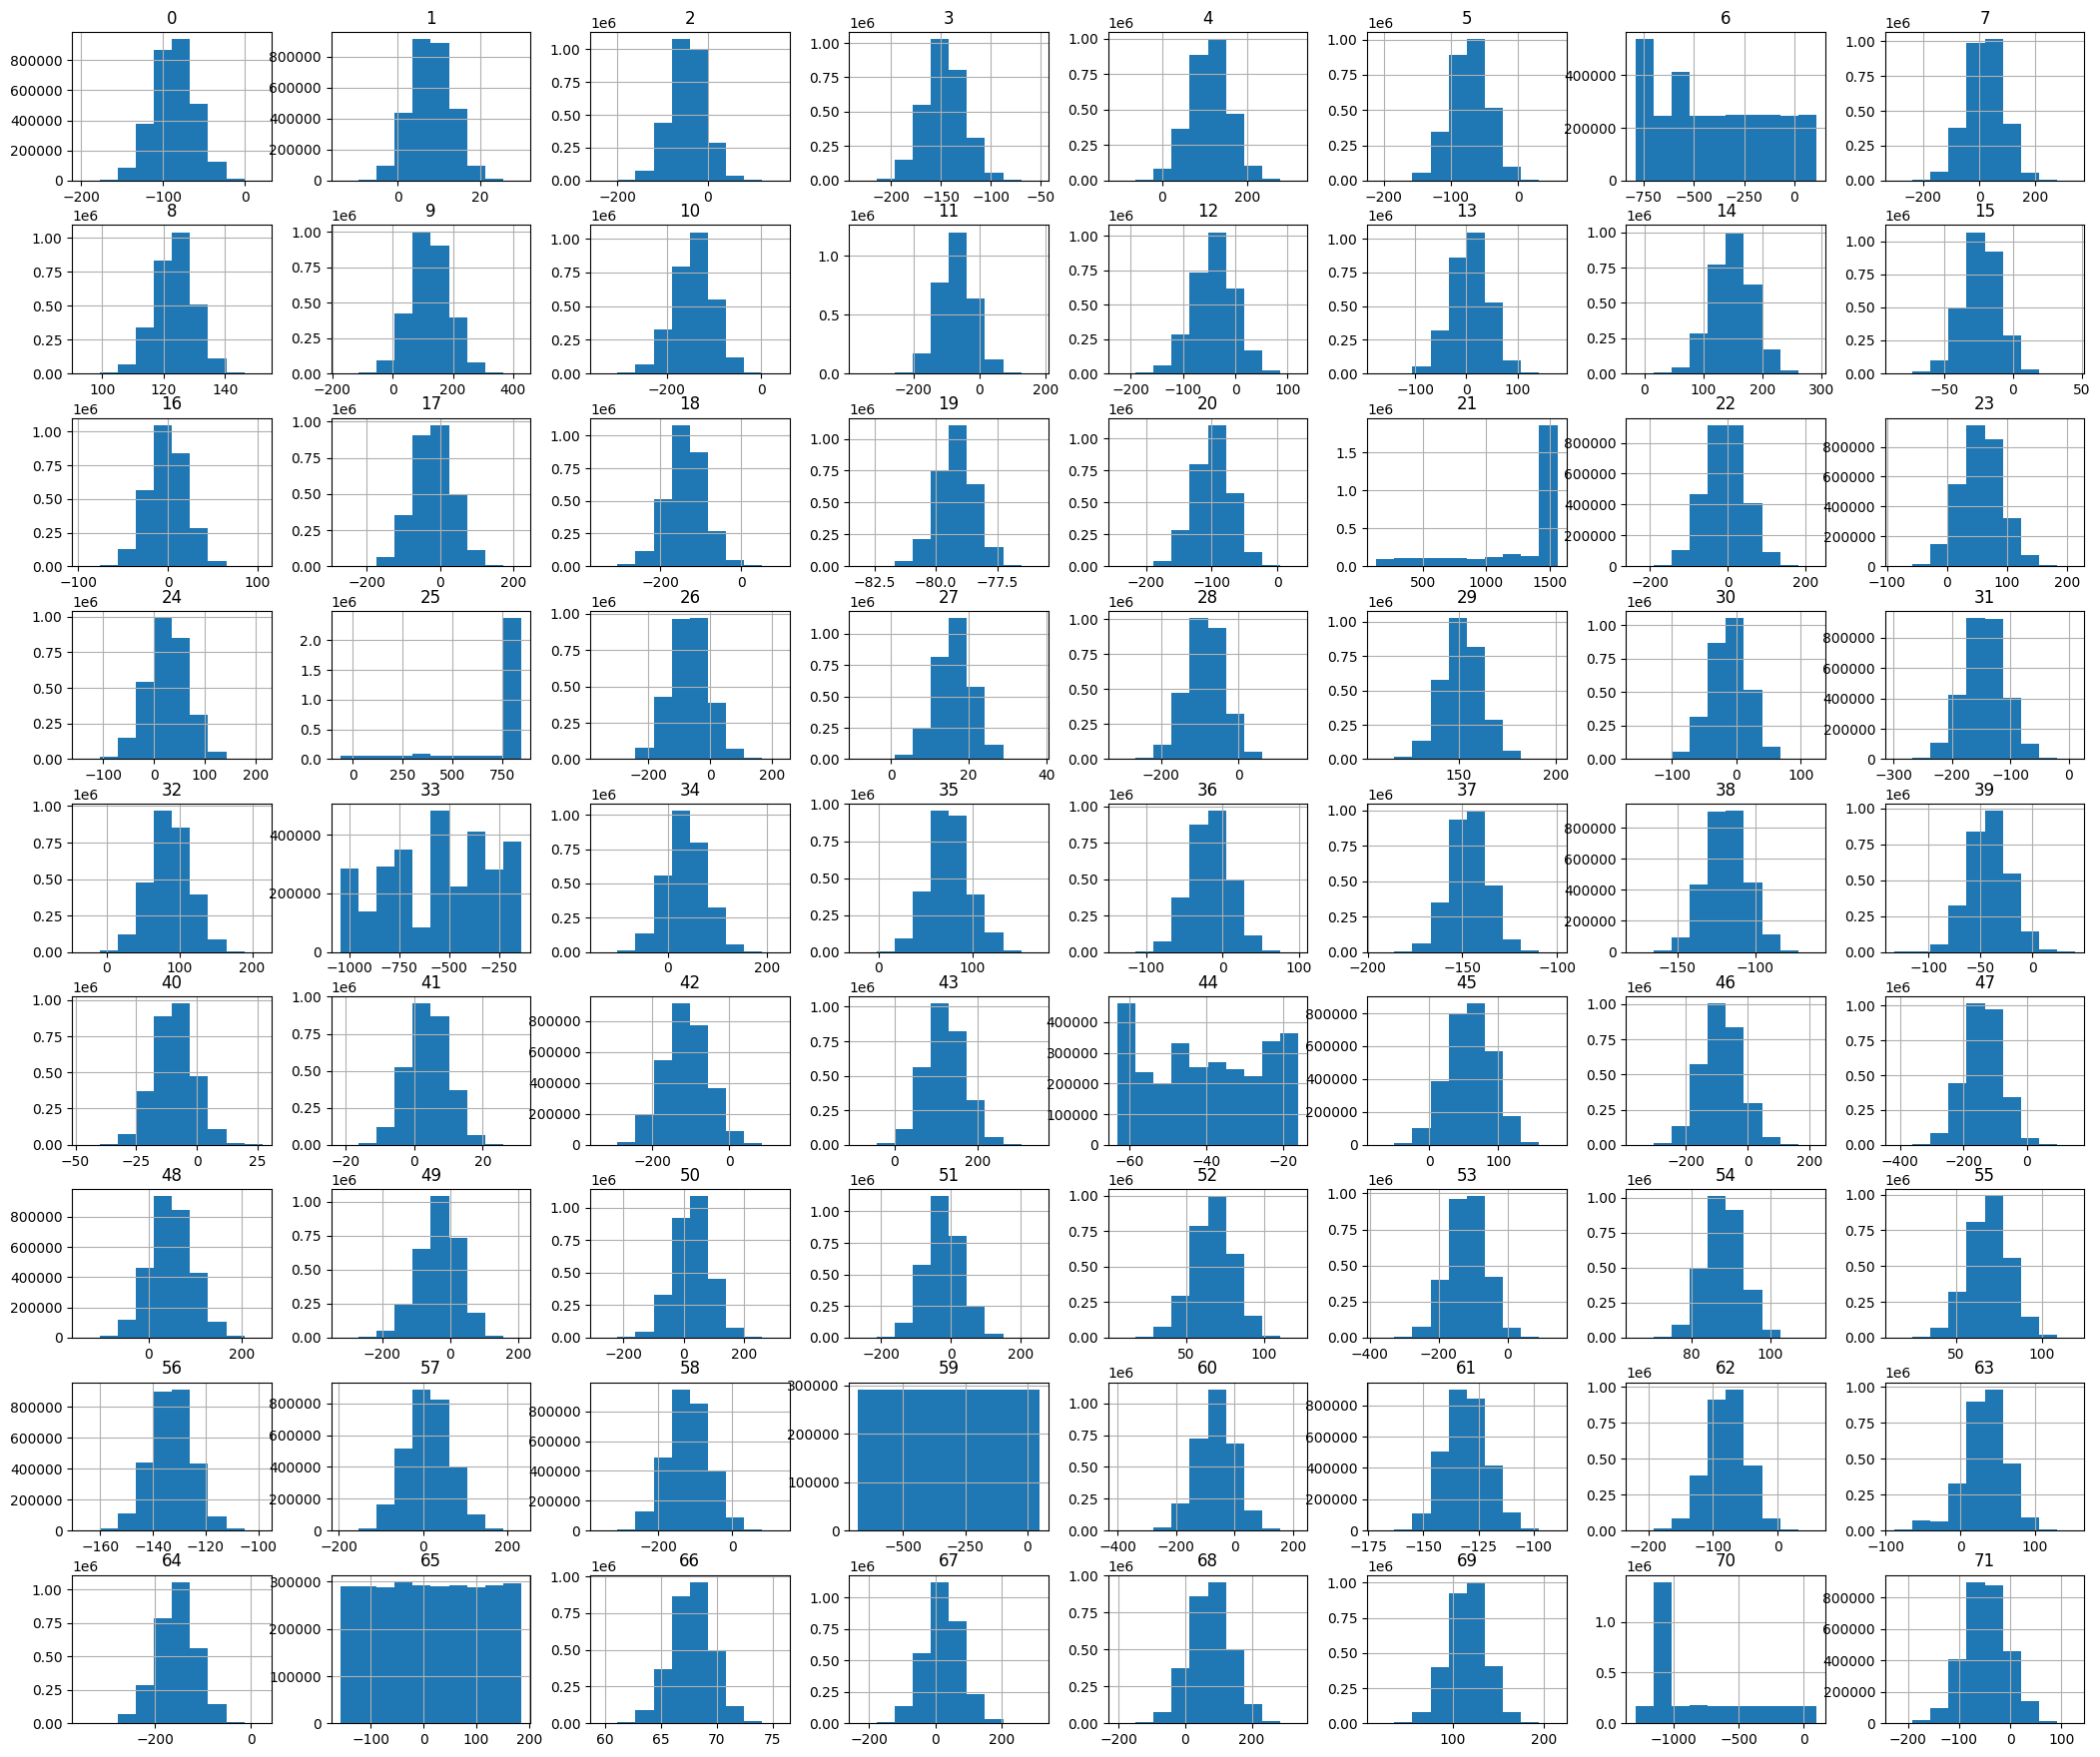

CPU times: user 1min 10s, sys: 4.49 s, total: 1min 15s
Wall time: 1min 15s


In [17]:
%%time
info_about_datas(data_base)

В данном датасете отсутствуют пропуски, дубликаты. Все колонки имеют числовые значения (как положительные, так и отрицательные). В большистве колонок распределение данных похоже на нормальное, однако присутствуют колнки с нестандартными распределениями: 6, 21, 25, 33, 44, 59, 65 и 70.

Рассмотрим столбец № 6.

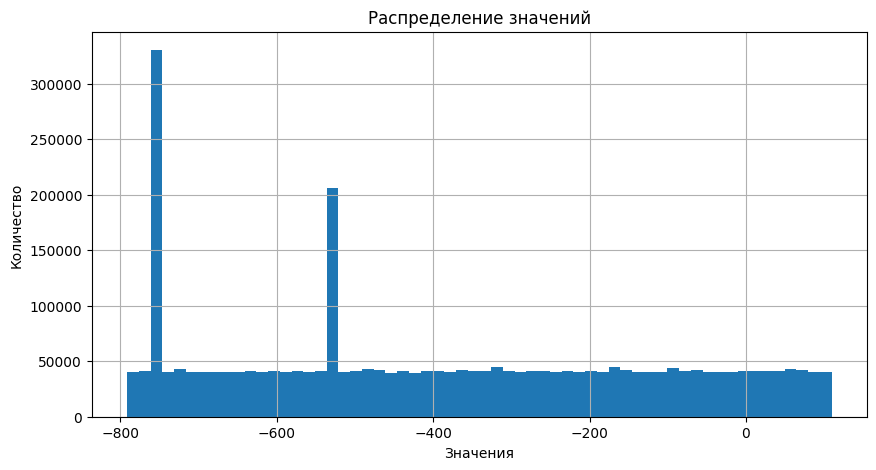

In [18]:
data_base['6'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

Заметно, что есть два (пика) наиболее популярных значения, когда как все остальные распределены равномерно по всему диапазону. Найдем эти популяпные значения.

In [19]:
data_base['6'].value_counts()

6
-759.626065    287090
-530.124724    164815
-175.047853      3707
-92.055125       3622
-750.151074      2659
                ...  
-330.122001         1
-391.653137         1
-564.191131         1
-319.424598         1
-532.907338         1
Name: count, Length: 1927620, dtype: int64

Самые часто встречаемые значения: -759,626065 и -530,124724.

Рассмотрим столбец № 21.

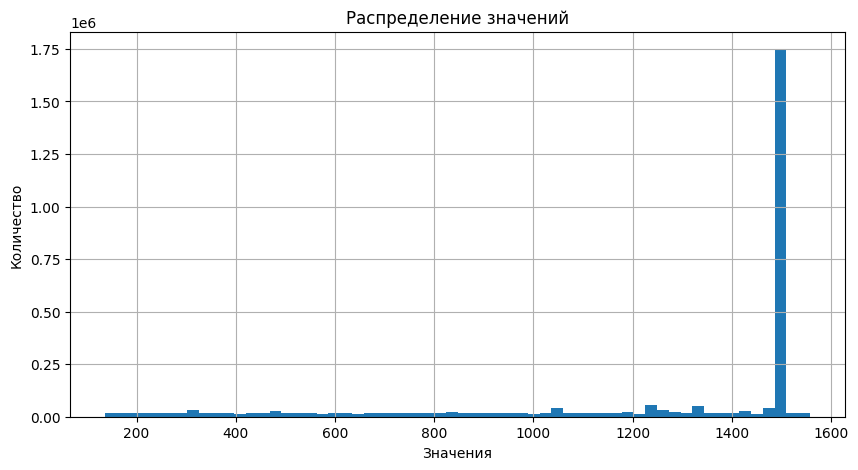

In [20]:
data_base['21'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

In [21]:
data_base['21'].value_counts()

21
1507.231274    1727961
1248.126198      40784
1342.641120      32933
1483.714136      23486
1054.205600      19951
                ...   
1474.918781          1
1068.453482          1
227.239190           1
1288.365543          1
889.961374           1
Name: count, Length: 715856, dtype: int64

Виден один пик, так как особо популярно значение 1507,231274, остальные значения более менее равномерно рапределены.

Столбец № 25.

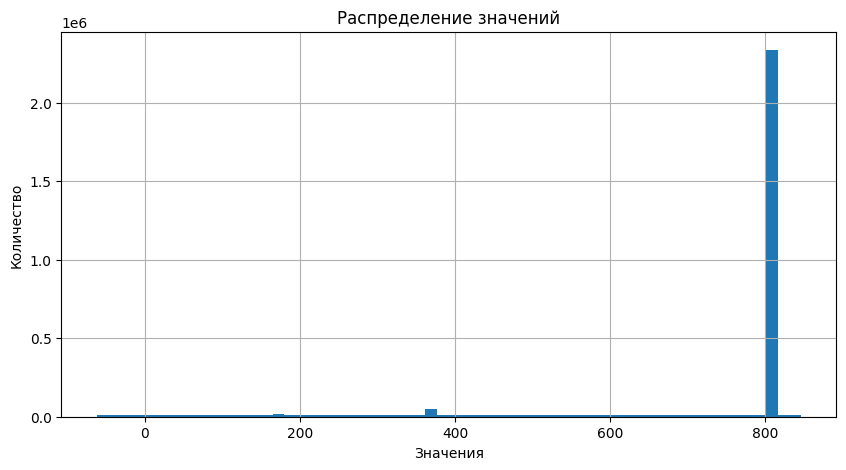

25
813.770071    2323620
366.779583      43208
175.595709       6585
514.955051       1329
701.226241       1230
               ...   
572.442724          1
72.804550           1
445.801020          1
722.049556          1
585.357843          1
Name: count, Length: 328121, dtype: int64

In [22]:
data_base['25'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['25'].value_counts()

Также видим наиболее часто встречаемое значение 813,770071.

Столбец № 33.

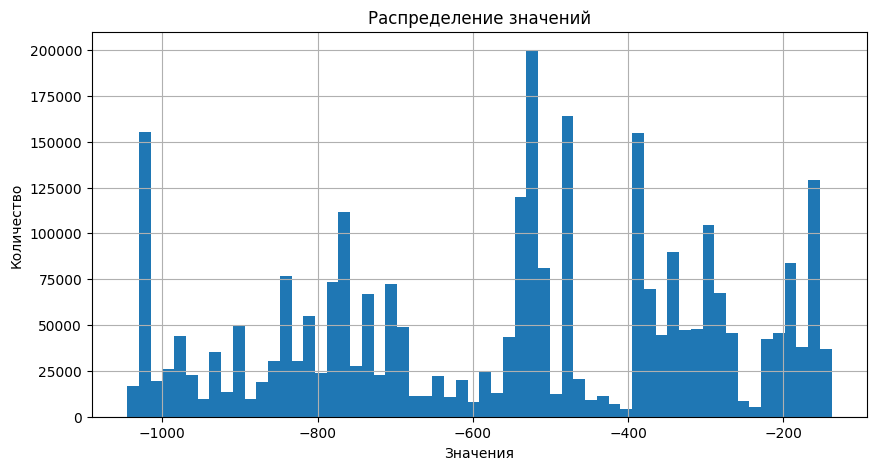

33
-529.295053     182985
-156.249890     124257
-1018.469545    121575
-537.183707     109763
-481.586956      99822
                 ...  
-474.818000          1
-250.815657          1
-709.168147          1
-317.564470          1
-469.273294          1
Name: count, Length: 4048, dtype: int64

In [23]:
data_base['33'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['33'].value_counts()

Здесь нет равномерного распределения. Присутствуют различные пики.

Столбец № 44.

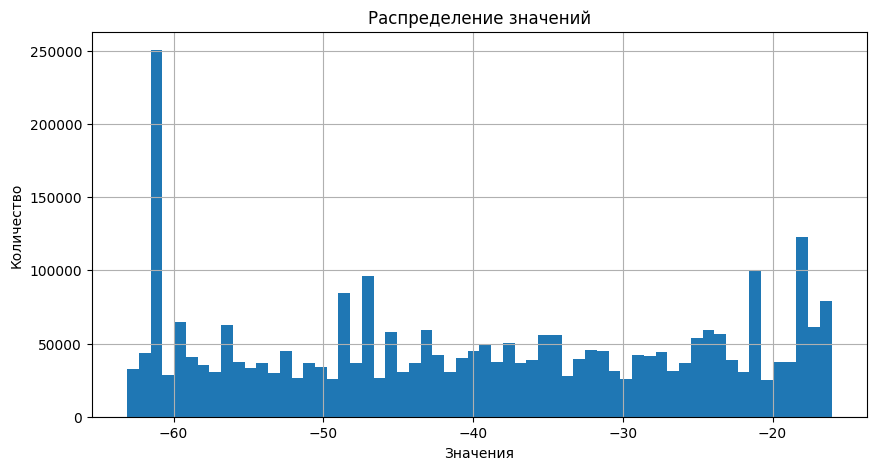

44
-61.441417    181193
-18.251750     96918
-47.166102     44537
-16.440254     34809
-21.092403     28188
               ...  
-34.560246         1
-35.341826         1
-31.996993         1
-25.015880         1
-52.024123         1
Name: count, Length: 44247, dtype: int64

In [24]:
data_base['44'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['44'].value_counts()

Ситуация аналогична большинству расмотренных случаев: имеется наиболее популярное значение, остальные данные распределены равномерно.

Столбец № 59.

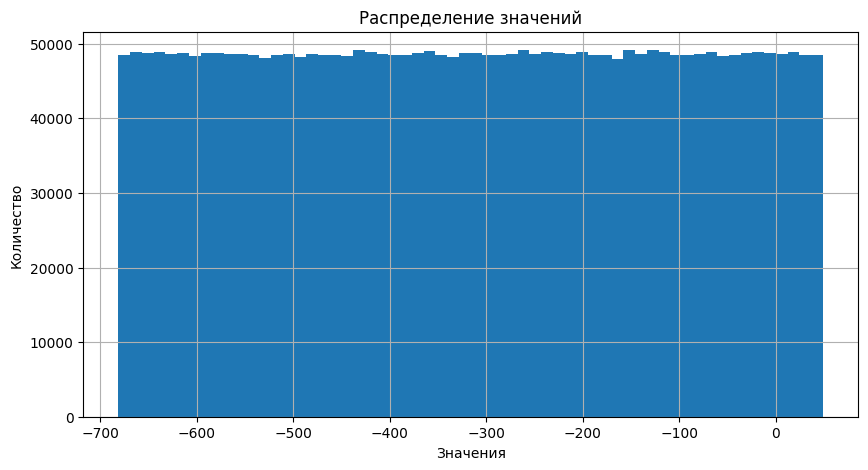

59
-230.403784    2
-648.713954    2
-52.720223     2
-465.642490    2
-364.892451    2
              ..
-653.789834    1
-519.132927    1
-294.947843    1
-385.537224    1
-409.243837    1
Name: count, Length: 2916064, dtype: int64

In [25]:
data_base['59'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['59'].value_counts()

Здесь признак встречается у товаров не более 2 раз, то есть можно сказать, что признак состоит (практически) из уникальных значений.

Столбец № 65.

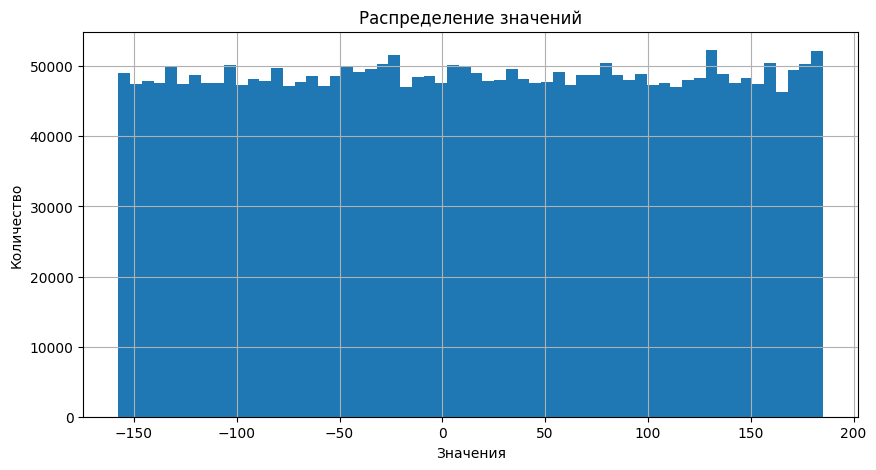

65
-21.533007     3318
 181.959582    2658
-81.475771     2367
 182.446349    2063
 130.450168    1932
               ... 
-113.198381       1
-108.942287       1
 87.570728        1
 58.706810        1
-5.081259         1
Name: count, Length: 2502958, dtype: int64

In [26]:
data_base['65'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['65'].value_counts()

Присутствует равномерное распределение значений, за некоторыми (редковстречаемыми) исключениями определённых значений.

Столбец № 70.

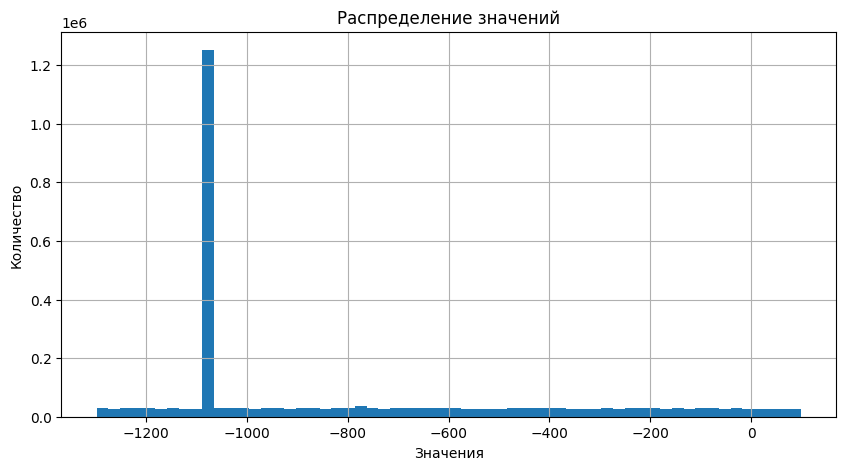

70
-1074.464888    1223397
-782.676180        6867
-597.491204         845
-799.363667         149
-891.219087         148
                 ...   
-459.505081           1
-994.524768           1
 34.754797            1
 82.667080            1
-1073.826170          1
Name: count, Length: 1573822, dtype: int64

In [27]:
data_base['70'].hist(bins=60,figsize=(10,5))
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

data_base['70'].value_counts()

И снова равномерное распределение значений с пиковым значением -1074,464888.

**Вывод** анализа датасета base:
- отсутствуют пропуски и дубликаты в данных;
- большинство признаков распределены нормально;
- присутствуют признаки, в которых данные распределены равномерно по всему диапазону, а также присутствуют пики (наиболее популярные значения);
- присутствуют признаки с равномерным распределением данных (или очень схожим с равномерным распределением).

#### Датасет **train**

Проверим наличие пропусков, дубликатов, выведем основную информацию и построим графики распределения значений в колонках.

Количество пропусков:


0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
target    0
Length: 73, dtype: int64

Кол-во товаров-дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      10000

None

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


Распределение значений в колонках:


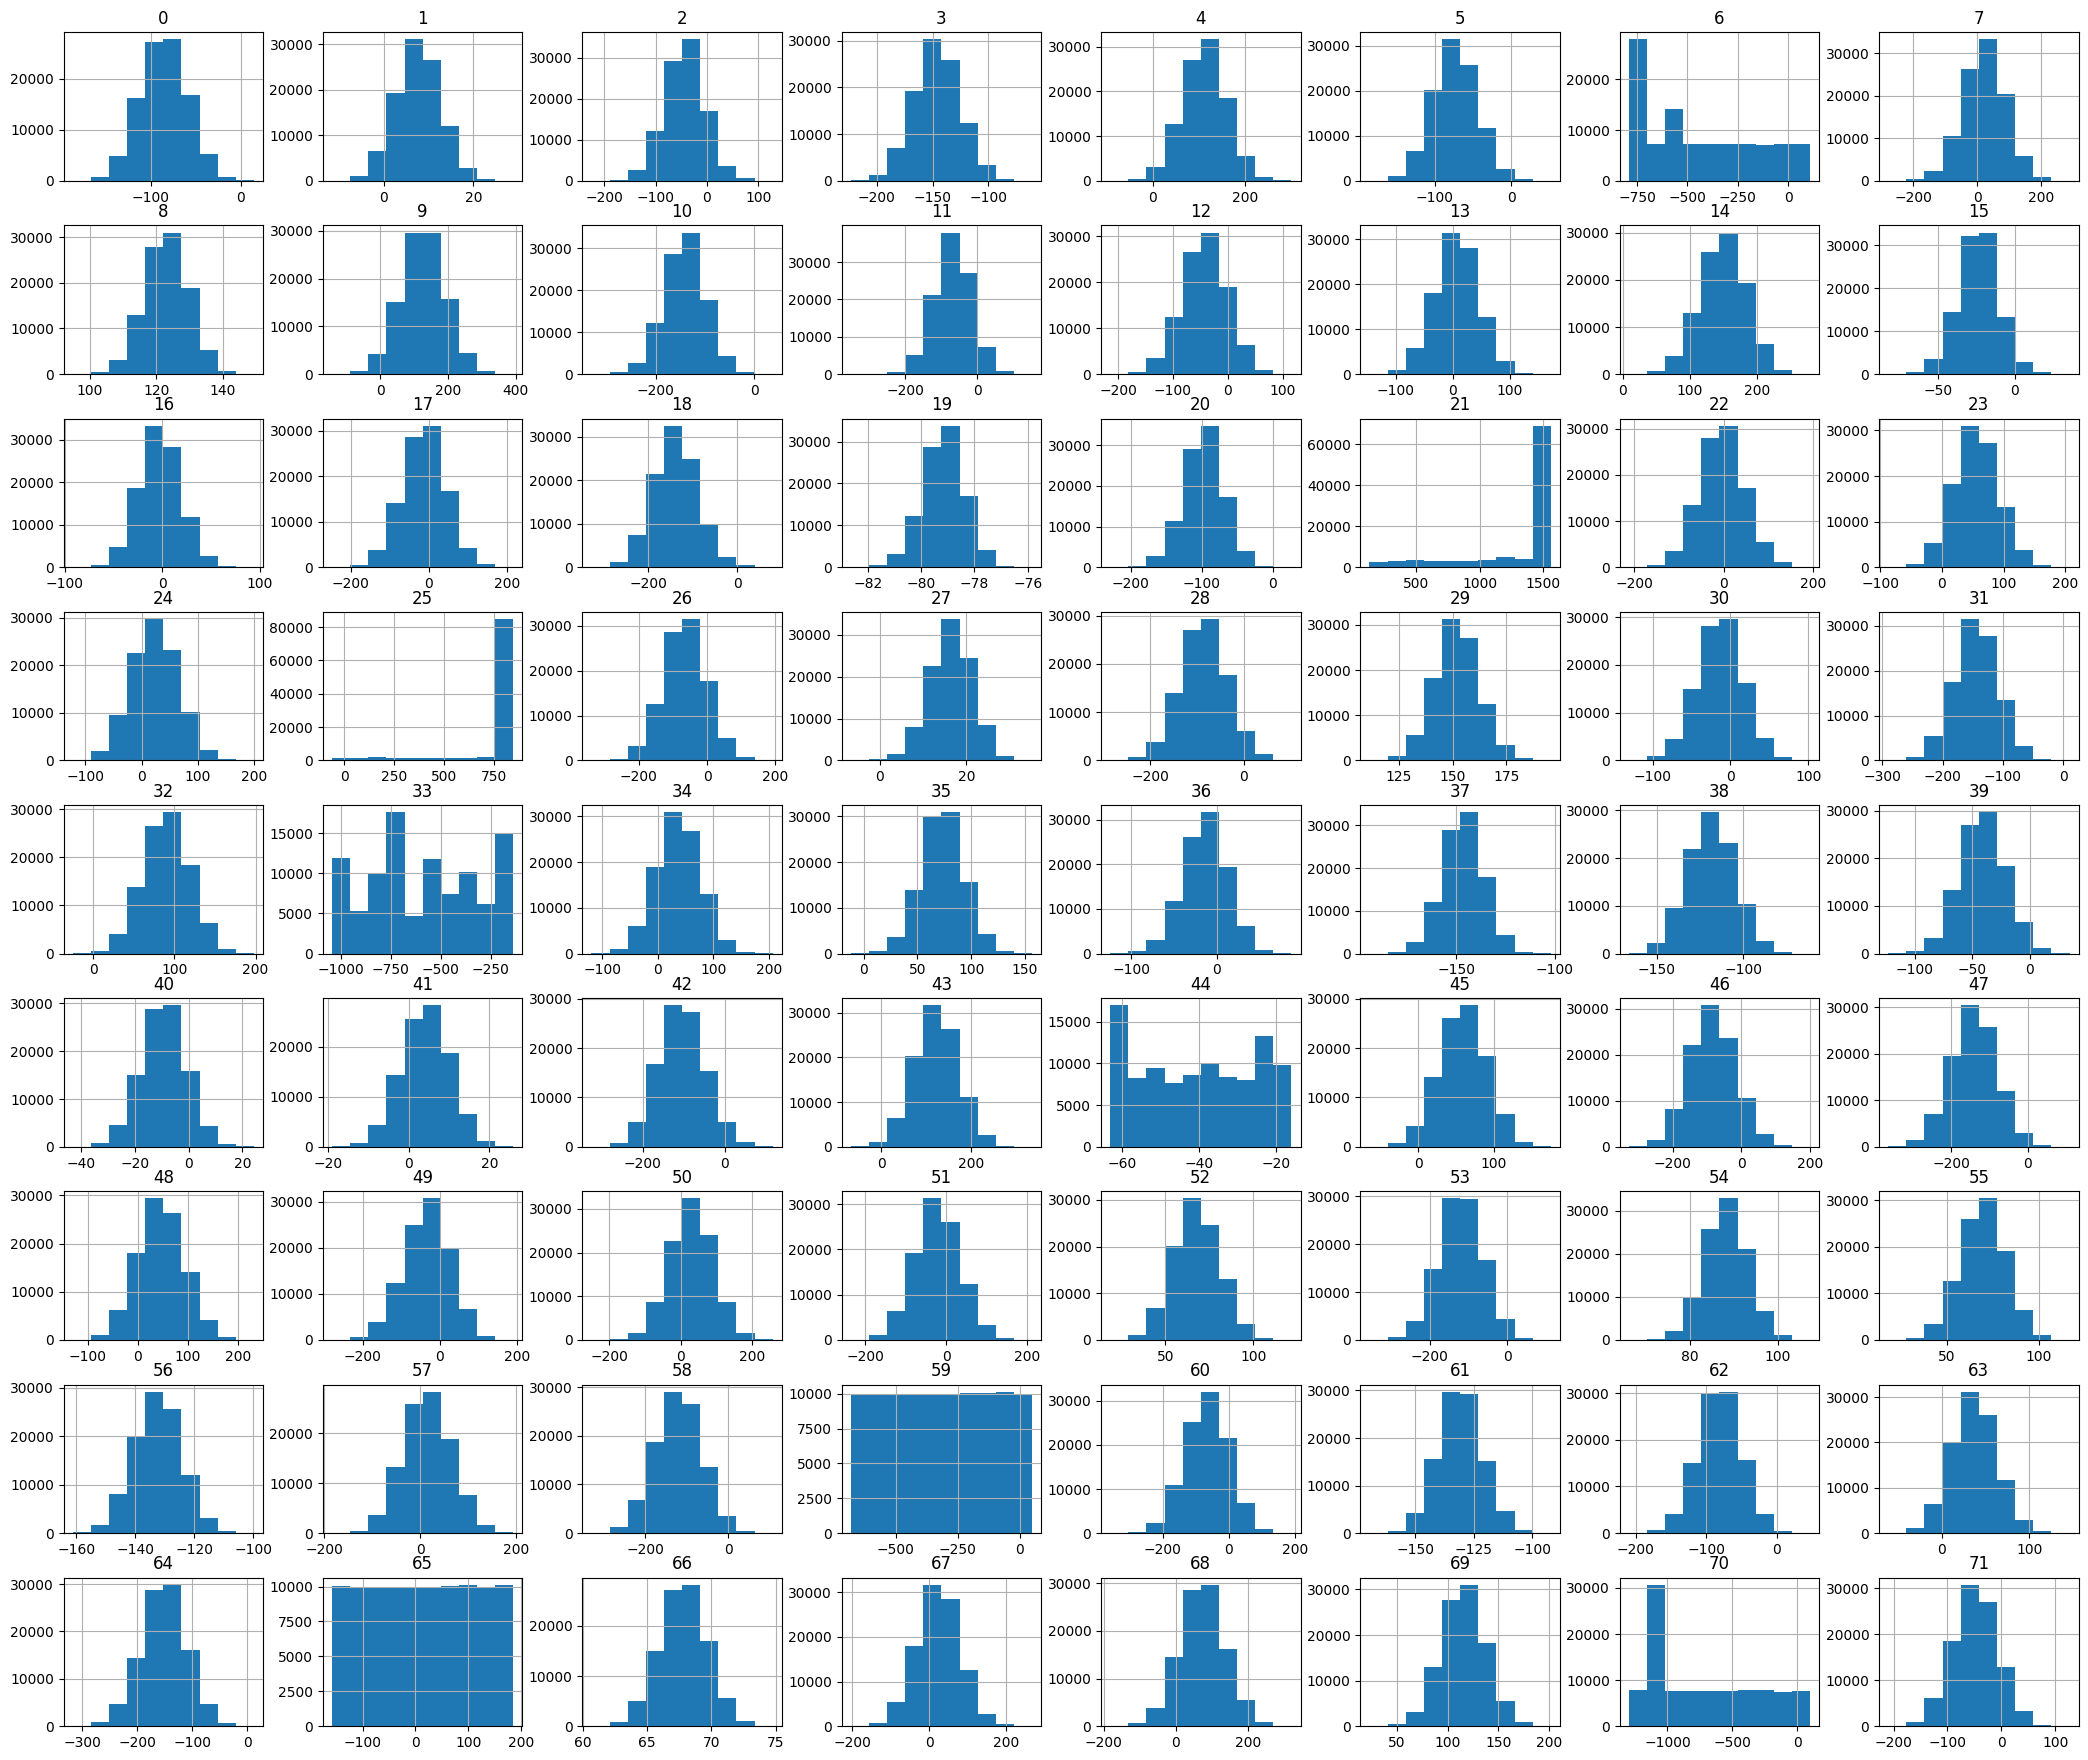

CPU times: user 9.82 s, sys: 23.7 ms, total: 9.84 s
Wall time: 9.84 s


In [28]:
%%time
info_about_datas(data_train)

**Вывод** анализа датасета train:

- Отсутствуют пропуски и дубликаты. У большинства признаков распределение данных схоже с нормальным.
- В признаках 6, 21, 25, 44, 70 распределение данных похоже на равномерное с явными пиками популяреых значений.
- В признаках 59 и 65 похожее на равномерное распределение данных.

*(Данный датасет похож на base)*

#### Датасет **validation**

Проверим наличие пропусков, дубликатов, выведем основную информацию и построим графики распределения значений в колонках.

Количество пропусков:


0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

Кол-во товаров-дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20     

None

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


Распределение значений в колонках:


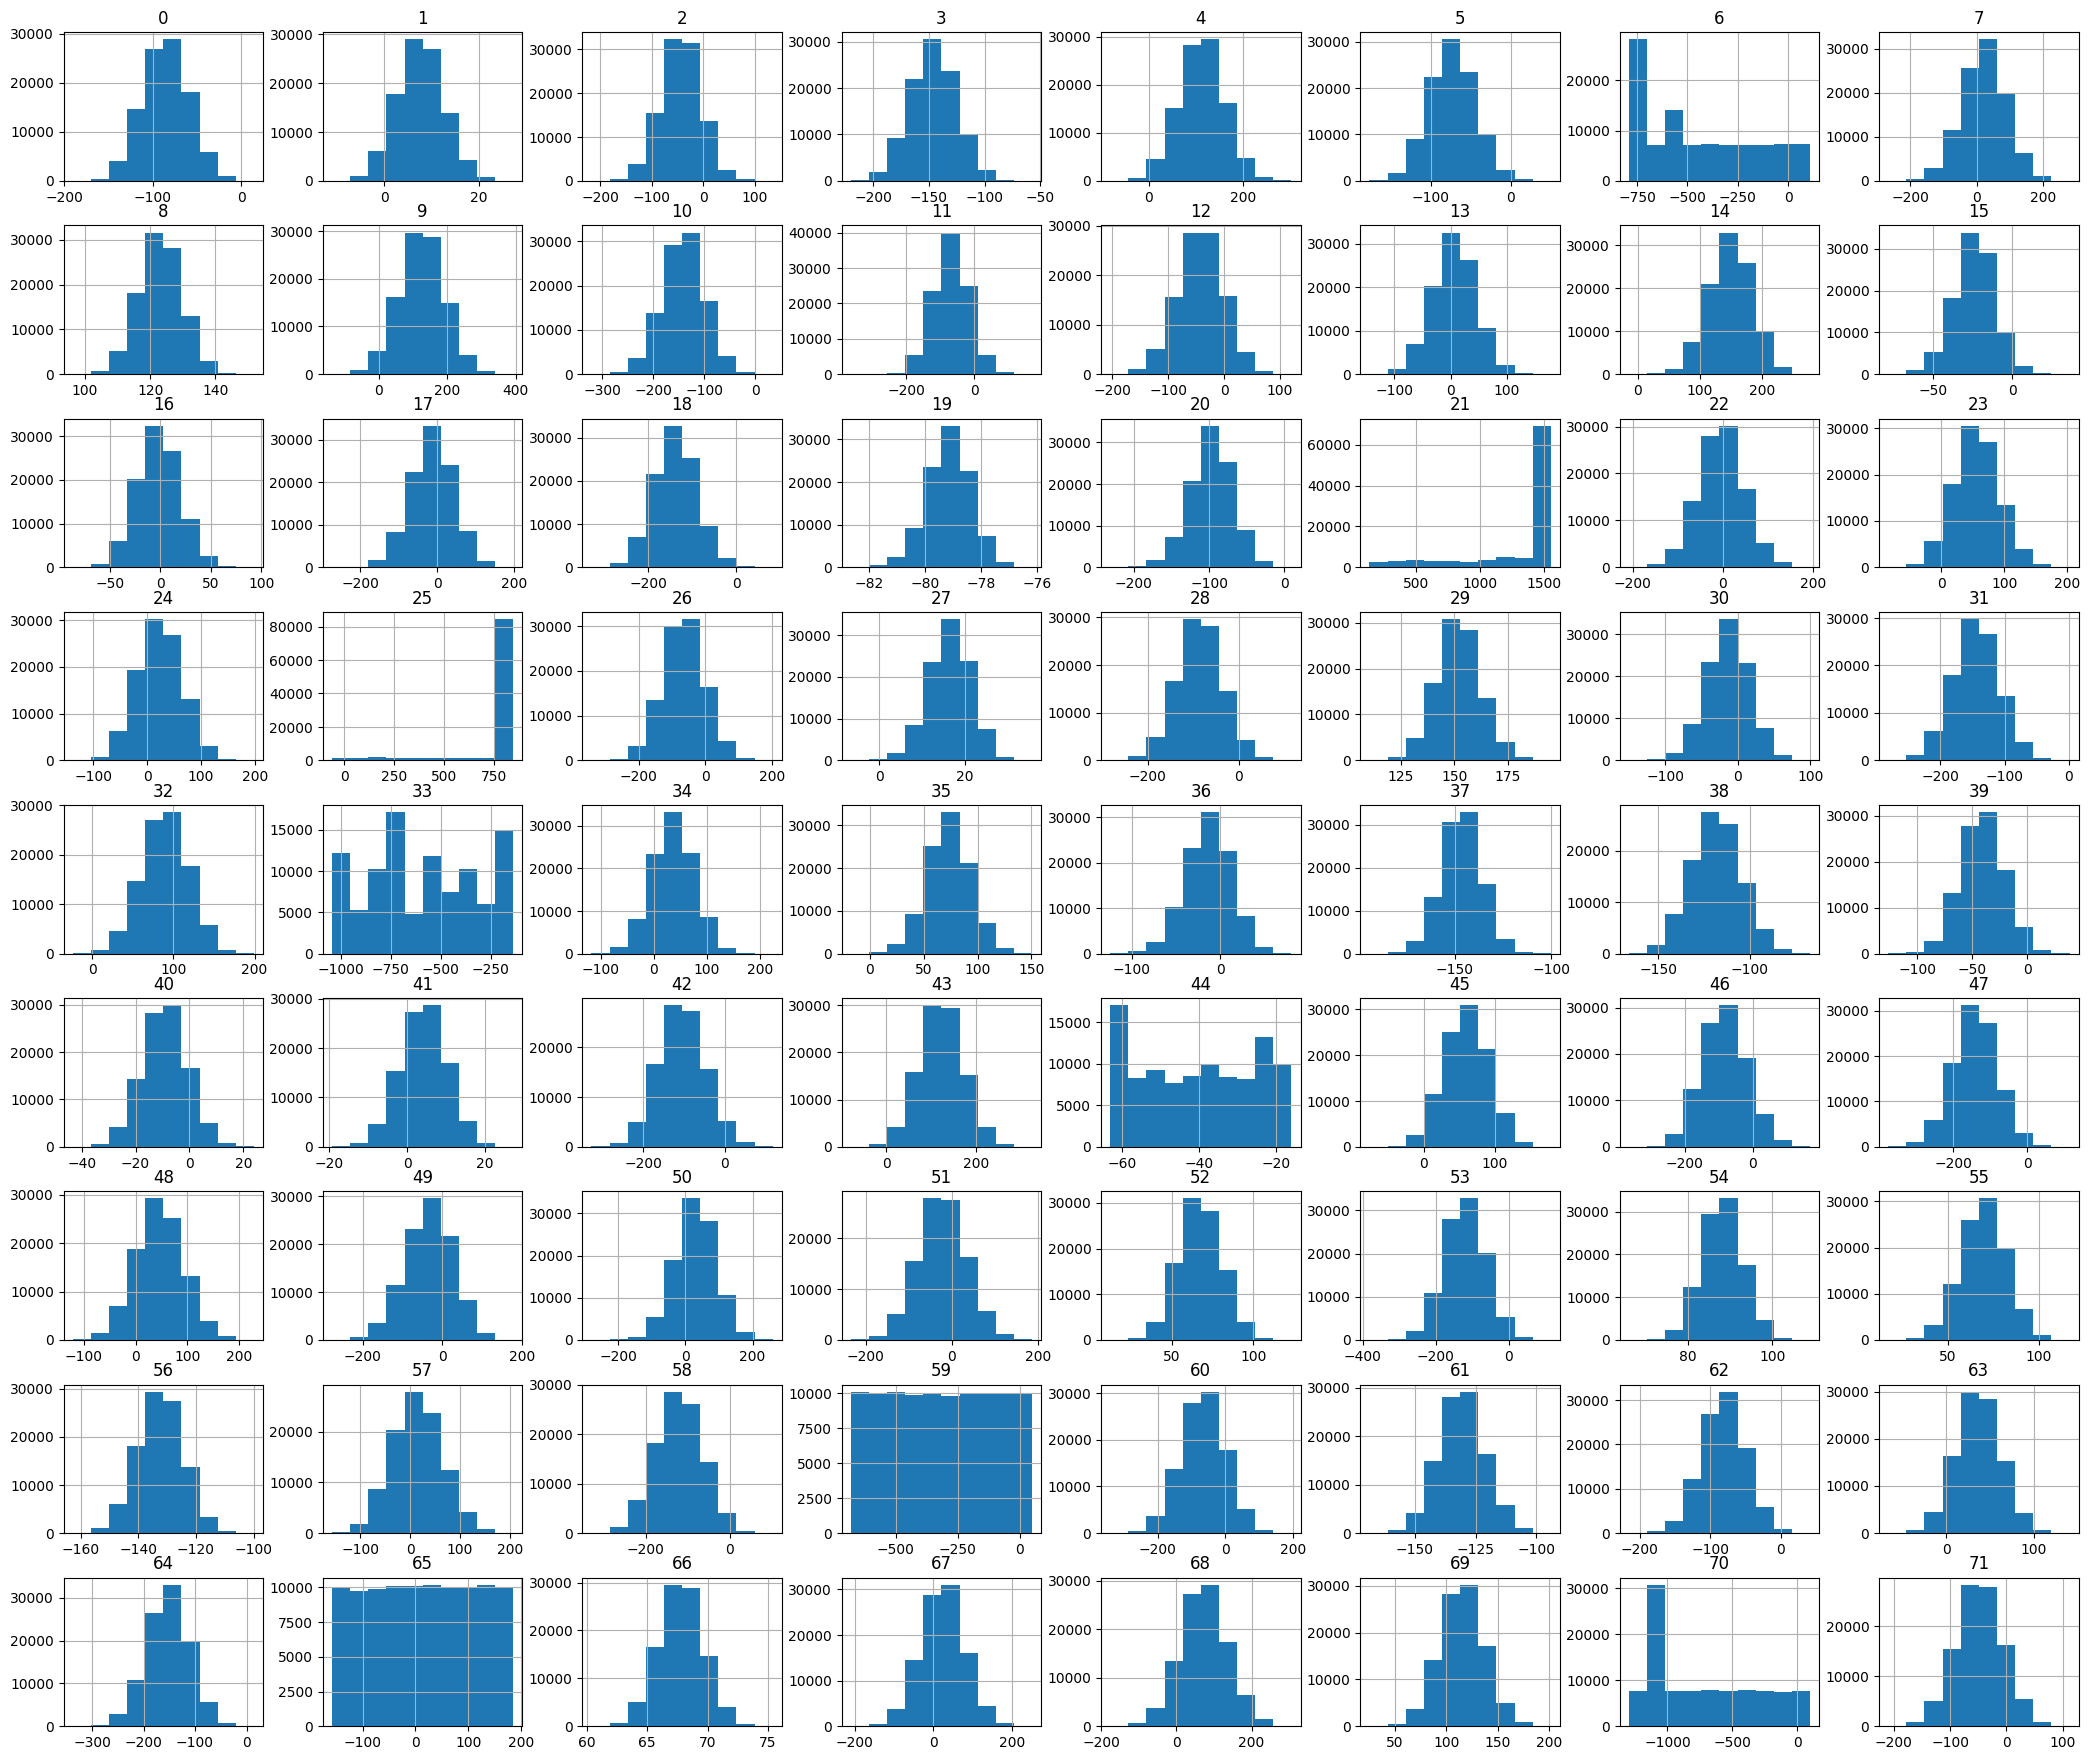

CPU times: user 10.2 s, sys: 19.4 ms, total: 10.2 s
Wall time: 10.2 s


In [29]:
%%time
info_about_datas(data_valid)

Мы видим, что здесь аналагичная ситуация, как и в двух предыдущих датасетах.

#### Датасет **validation_answer**

In [30]:
data_answer.info()
print('Кол-во дубликатов:', data_answer.duplicated().sum())
display(data_answer['expected'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во дубликатов: 8498


expected
210304-base     7
509802-base     6
88699-base      6
225867-base     6
175303-base     5
               ..
2249636-base    1
1328584-base    1
583783-base     1
1017550-base    1
336472-base     1
Name: count, Length: 91502, dtype: int64

Пропуски отсутствуют. Мы видим, что разным товарам могут соответсвовать одинаковые подборки товара, что вполне логично.

### Корреляции между признаками

Рассмотрим, как взаимосвязаны признаки между собой на примере датасета base.

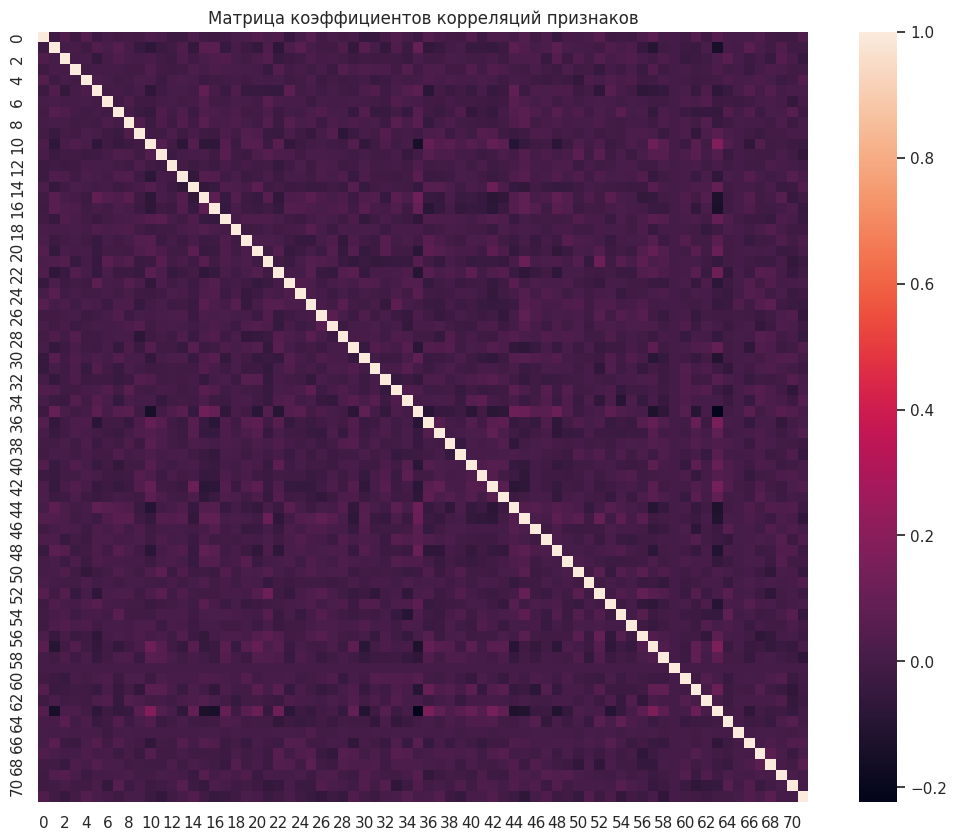

In [31]:
sns.set(rc = {'figure.figsize':(13, 10)})
sns.heatmap(data_base.corr(), square=True)
plt.title('Матрица коэффициентов корреляций признаков')
plt.show()

**Вывод**

По итогу анализа данных в датасетах, были сделаны следующие выводы:

1. В датасетах base, train, validation:
- отсутствуют пропуски и дубликаты
- большинство признаков распределены нормально;
- присутствуют признаки, в которых данные распределены равномерно по всему диапазону, а также присутствуют пики (наиболее популярные значения);
- присутствуют признаки с равномерным распределением данных (или очень схожим с равномерным распределением).
2. В датасете validation_answer присутствуют дубликаты, связанные с похожестью одного товара с несколькими другими.
3. Признаки между собой не имеют яркой зависимости (сильной корреляции).


### Масштабирование данных

В признаках присутствуют как и положительные значения, так и отрицательные, с разными размахами значений. Для последующей корректной работы необходимо отмасштабировать признаки, чтобы не возникало ситуации, когда одно значение более значимо, чем другое.

Запишем целевой признак в отдельный датафрейм `target_train`.

In [32]:
target_train = data_train['target']
data_train.drop('target', axis=1, inplace=True)

Проведем масштабирование с помощью StandardScaler.

In [33]:
scaler = StandardScaler()
scaler.fit(data_base)
base_transform  = scaler.transform(data_base)
train_transform = scaler.transform(data_train)
valid_transform = scaler.transform(data_valid)

# Обучение моделей

Для решения задачи матчинга используем два следующих способа:
- связку `KMeans` + `NearestNeighbors`;
- модель `FAISS`.

## Оптимальное число кластеров

Для начала найдем оптимальное количество кластеров. Используем «метод локтя». Так как данных много, попробуем использовать метод MiniBatchKMeans.


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: 

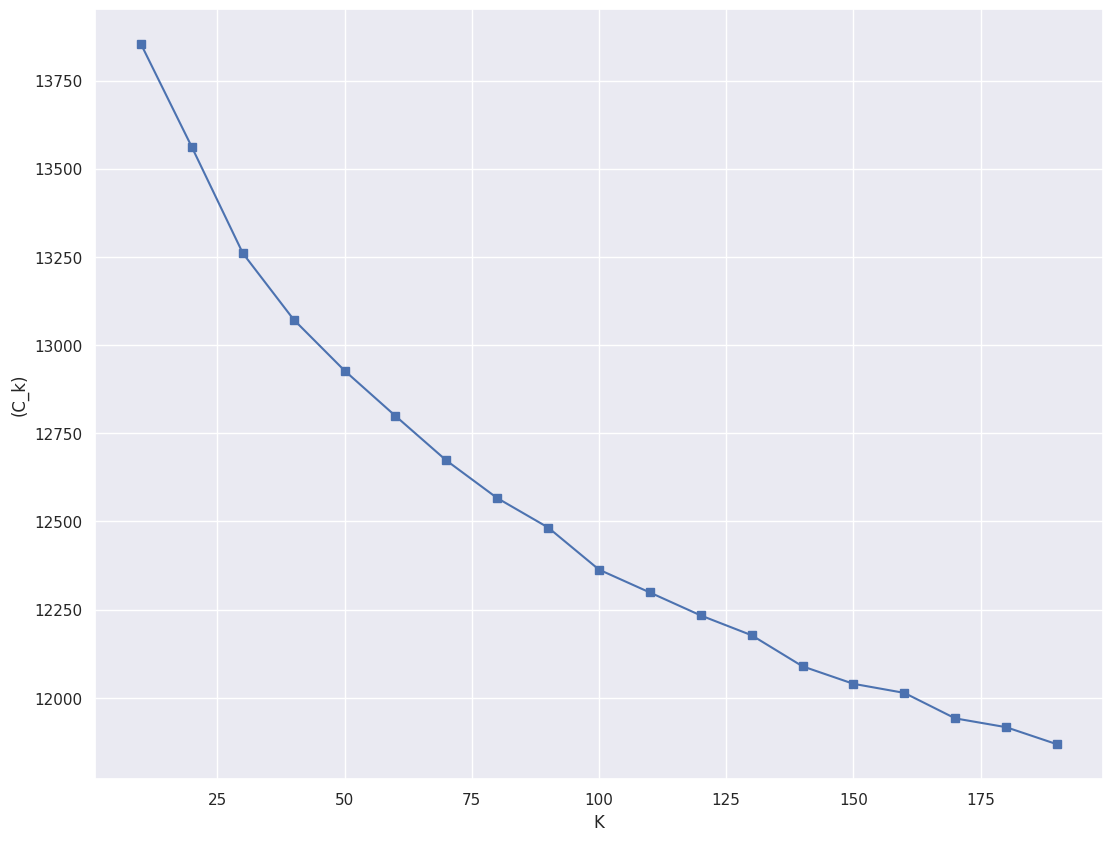

CPU times: user 7min 22s, sys: 9.8 s, total: 7min 32s
Wall time: 2min 6s


In [34]:
%%time
inertia = []
for k in range(10,200,10):
    mbk = MiniBatchKMeans(n_clusters=k, init='random', random_state=1).fit(base_transform)
    inertia.append(np.sqrt(mbk.inertia_))
plt.plot(range(10,200,10),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

Получился не совсем наглядный 'локоть', так как необходимо найти ту точку, после которой график начнёт почти линейно уменьшаться, можно предположить, что лучшее решение около k = 80. 

Попробуем найти количество кластеров с помощью метода KMeans, но используя не всю выборку, а только ее часть (чтобы уменьшить время компилирования).

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

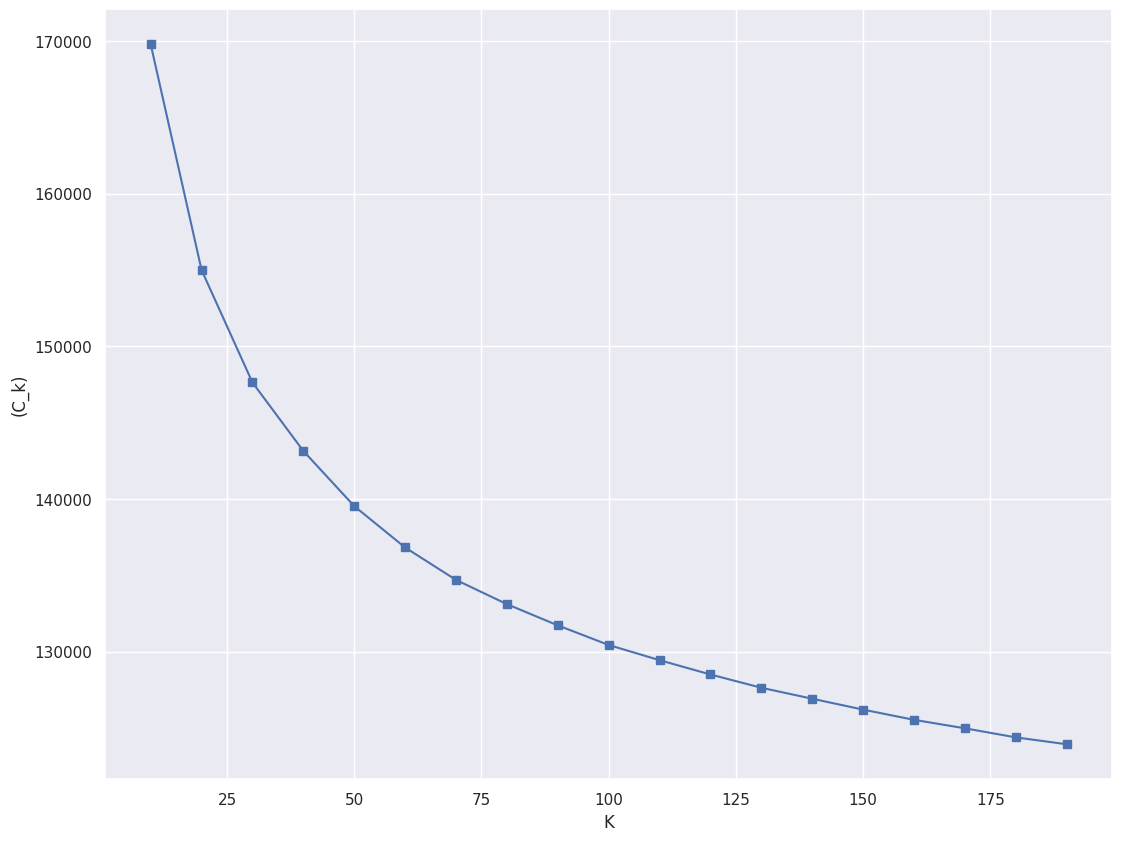

CPU times: user 49min 13s, sys: 2min 54s, total: 52min 7s
Wall time: 13min 19s


In [35]:
%%time
data_base_test = data_base.sample(100000)
base_test_transform  = scaler.transform(data_base_test)

inertia = []
for k in range(10,200,10):
    km = KMeans(n_clusters=k, init='k-means++', random_state=1).fit(data_base_test)
    inertia.append(np.sqrt(km.inertia_))
plt.plot(range(10,200,10),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

Здесь также ситуация не однозначна, поэтому останавливаем свой выбор на количестве кластеров, равным 80.

## `KMeans` + `NearestNeighbors`

KMeans: основная идея алгоритма K-средних заключается в том, что случайным образом выбирается K центров, далее рассчитывается расстояние от каждой точки до этих центров и выбирается ближайший, таким образом создаётся K множеств; затем среди созданных множеств находятся новые центры (уже не искусственным образом) и алгоритм повтояреятся до тех пор, пока центры не перестянут изменяться.

In [36]:
%%time

kmeans_model = KMeans(n_clusters=80, init='k-means++', random_state=1)
kmeans_model.fit(train_transform)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2min 22s, sys: 8.29 s, total: 2min 30s
Wall time: 38.8 s


KMeans(n_clusters=80, random_state=1)

Предскажем, к какому кластеру принадлежит каждая точка данных. 

1. Для этого обратимся к атрибуту `labels_`. 
2. Чтобы узнать, где находится центр каждого кластера, аналогичным способом обратимся к атрибуту `cluster_centers_`.

In [41]:
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

In [46]:
knn = NearestNeighbors(n_neighbors=5)

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Не понимаю, как искать соседей методом NearestNeighbors, Но при этом учитывать полученные кластеры в Kmeans (искала примеры кода, но не нашла).

Словами было рассказано, что необходимо сделать:
1. Шкалирование
2. Кластеризация
3. Подбор кол-ва кластеров
4. Запись центроидов
5. К товару из data_valid расчитать KNN какой центроид ближе всего к этому товару
6. Берем товары из найденного кластера (п.5) и с KNN считаем топ 5 ближайших товаров

Проблема в реализации пунктов 5 и 6.
    
Нам показали пример наиболее правильного (и сложного) решения данной задачи, снизу попытка это повторить, но понимания так такого нет((((( Проблема начинается на этапе: Поиск похожих. Найдём индексы k похожих векторов для среза....
    
Ниже представлен сам этот код.
</div>

In [ ]:
def nested_cluster_nn_search(df : pd.DataFrame, df_eval : pd.DataFrame,
                             n_clusters = 80,
                             nn_sample_size = 100000, k = 5,
                             model = KMeans, seed = SEED, verbose = 1):
    if verbose > 0:
        def verboseprint(*args):
            for arg in args:
                print(arg),
            print
    else:
        verboseprint = lambda *a: None

    # Зададим списки для сбора кластеров и центроид.
    centroids = []
    clusters = []

    verboseprint('Начало кластеризации.')
    verboseprint('-' * 10)

    clust_start = perf_counter()

    ## Кластеризация.
    # Создадим экземлпяры класса Kmeans 
    model_n = model(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=SEED)

    # Получим центроиды и кластеры 
    clust_n = model_n.fit(df)
    centroids = clust_n.cluster_centers_

    clust_time = perf_counter() - clust_start

    verboseprint('~' * 70, '\n')
    verboseprint(f'Начало поиска {k} похожих для {nn_sample_size} векторов.')
    verboseprint('-' * 10)

    search_start = perf_counter()

    nn = NearestNeighbors(n_neighbors=1, radius=1.0)
    nn_k = NearestNeighbors(n_neighbors=k, radius=1.0)
    index_nn = []
    df_idxs_level_3 = []

    ## Поиск похожих.
    # Найдём индексы k похожих векторов для среза тестового датафрейма 
    # размером nn_train_sample_size.
    for idx in trange(df_eval.iloc[:nn_sample_size].shape[0]):
        # Обучим модель и найдём похожие центроиды.
        nn.fit([i[0] for i in centroids])
        index = nn_k.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1), 
            return_distance=False
        )

        # Найдем индекс похожего центроида для передачи
        final_centroid = centroids[int(index)][1]
        for idx, el in enumerate([i[0] for i in centroids]):
            if np.array_equal(el, final_centroid):
                final_centroid_idx = idx

        nn_k.fit([i[1] for i in centroids][final_centroid_idx].values)
        index_level_3 = nn_k.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1), 
            return_distance=False
        )

        df_idxs_level_3 = []
        for idxs_level_3 in np.squeeze(index_level_3):
            vector = (
                [i[1] for i in level_2_3][final_centroid_idx]
                .iloc[idxs_level_3]
            )
            df_idxs_level_3.append(
                df.index.get_loc(df.loc[df.eq(vector, 1).all(1)].index[0])
            )

        index_nn.append(df_idxs_level_3)

    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    acc = 0
    for t, el in zip(target_train.values.tolist(), index_nn):
        acc += int(t in [base_index[r] for r in el])

    search_time = perf_counter() - search_start

    verboseprint('\n', '-' * 10, 'Конец работы.')

    # Выведем метрику и время исполнения.
    return round(100 * acc / len(index_nn), 3), clust_time, search_time

In [ ]:
# nested_cluster_nn_search(df_base_rs, df_train_rs, 
#                          n_clusters = 80
#                          model=KMeans, 
#                          nn_sample_size=1000)

In [ ]:
# # Функция 3-уровневой кластеризации.
# def nested_cluster_nn_search(df : pd.DataFrame, df_eval : pd.DataFrame,
#                              n_clusters_1 = 10, n_clusters_2 = 100,
#                              nn_sample_size = 100000, k = 5,
#                              model = KMeans, seed = SEED, verbose = 1):
#     '''
#     Returns accuracy@k for given dataframes of vectors by
#     - 3-layer clustering;
#     - searching for k similar in centroids of both levels and resulting 
#       clusters using NearestNeighbors:
#       1 neighbor for centroids on both levels, k neighbors for resulting
#       clusters;
#     - comparing indices to targets.

#     - Arguments:
#       - df: pd.DataFrame. Dataframe of vectors to get matches from.
#       - df_eval: pd.DataFrame. Dataframe of vectors for matching.
#       - n_clusters_1: int. Number of clusters for the 1st level.
#       - n_clusters_2: int. Number of clusters for the 2nd level.
#       - nn_sample_size: int. Number of vectors to find matches for.
#       - k: int. Number of similar items to search for.
#       - model: model class. Accepts KMeans or MiniBatchKMeans.
#       - seed: any. Random numbers generator seed;
#       - verbose: int. Verbosity. 1 - verbose. 0 - silent.
#     '''

#     if verbose > 0:
#         def verboseprint(*args):
#             for arg in args:
#                 print(arg),
#             print
#     else:
#         verboseprint = lambda *a: None

#     # Зададим списки для сбора кластеров и центроид.
#     centroids_level_1 = []
#     clusters_level_1 = []
#     centroids_level_2 = []
#     clusters_level_2 = []
#     centroids_level_2_all = []

#     verboseprint('Начало кластеризации.')
#     verboseprint('-' * 10)

#     clust_start = perf_counter()

#     ## Кластеризация.
#     # Создадим экземлпяры класса Kmeans для каждого уровня 
#     # кластеризации для подходящей модели.
#     if model == KMeans:
#         model_n1 = model(n_clusters=n_clusters_1, 
#                          init='k-means++', n_init='auto', 
#                          random_state=SEED)
#         model_n2 = model(n_clusters=n_clusters_2, 
#                          init='k-means++', n_init='auto', 
#                          random_state=SEED)
#     elif model == MiniBatchKMeans:
#         model_n1 = model(n_clusters=n_clusters_1, 
#                          init='k-means++', n_init='auto', 
#                          batch_size=1536, random_state=SEED)
#         model_n2 = model(n_clusters=n_clusters_2, 
#                          init='k-means++', n_init='auto', 
#                          batch_size=1536, random_state=SEED)

#     # Получим центроиды первого и второго уровня и кластеры второго уровня.
#     # Первый уровень кластеризации.
#     clust_n1 = model_n1.fit(df)
#     centroids_level_1 = clust_n1.cluster_centers_
#     for i in trange(n_clusters_1):
#         clusters_level_1.append(df[clust_n1.labels_ == i])
#         # Второй уровень кластеризации.
#         clust_n2 = model_n2.fit(df[clust_n1.labels_ == i])
#         centroids_level_2.append(clust_n2.cluster_centers_)
#         for j in range(n_clusters_2):
#             centroids_level_2_all.append(clust_n2.cluster_centers_[j])
#             clusters_level_2.append(
#                 df[clust_n1.labels_ == i][clust_n2.labels_ == j]
#             )

#     # Соберём центроиды первого и второго уровня и центроиды второго 
#     # и кластеры третьего уровня в группы.
#     level_1_2 = []
#     level_2_3 = []
#     for i in range(n_clusters_1):
#         level_1_2.append([centroids_level_1[i], centroids_level_2[i]])
#     for i in range(n_clusters_1 * n_clusters_2):
#         level_2_3.append([centroids_level_2_all[i], clusters_level_2[i]])

#     clust_time = perf_counter() - clust_start

#     verboseprint('~' * 70, '\n')
#     verboseprint(f'Начало поиска {k} похожих для {nn_sample_size} векторов.')
#     verboseprint('-' * 10)

#     search_start = perf_counter()

#     nn = NearestNeighbors(n_neighbors=1, radius=1.0)
#     nn_k = NearestNeighbors(n_neighbors=k, radius=1.0)
#     index_nn = []
#     df_idxs_level_3 = []

#     ## Поиск похожих.
#     # Найдём индексы k похожих векторов для среза тестового датафрейма 
#     # размером nn_train_sample_size.
#     for idx in trange(df_eval.iloc[:nn_sample_size].shape[0]):
#         # Обучим модель и найдём похожие центроиды первого уровня.
#         nn.fit([i[0] for i in level_1_2])
#         index_level_1 = nn.kneighbors(
#             df_eval.iloc[idx].values.reshape(1,-1), 
#             return_distance=False
#         )

#         # Обучим модель и найдём похожие центроиды второго уровня.
#         nn.fit(level_1_2[int(index_level_1)][1])
#         index_level_2 = nn.kneighbors(
#             df_eval.iloc[idx].values.reshape(1,-1), 
#             return_distance=False
#         )
#         # Найдем индекс похожего центроида второго уровня для передачи
#         final_centroid = level_1_2[int(index_level_1)][1][int(index_level_2)]
#         for idx, el in enumerate([i[0] for i in level_2_3]):
#             if np.array_equal(el, final_centroid):
#                 final_centroid_idx = idx

#         nn_k.fit([i[1] for i in level_2_3][final_centroid_idx].values)
#         index_level_3 = nn_k.kneighbors(
#             df_eval.iloc[idx].values.reshape(1,-1), 
#             return_distance=False
#         )

#         df_idxs_level_3 = []
#         for idxs_level_3 in np.squeeze(index_level_3):
#             vector = (
#                 [i[1] for i in level_2_3][final_centroid_idx]
#                 .iloc[idxs_level_3]
#             )
#             df_idxs_level_3.append(
#                 df.index.get_loc(df.loc[df.eq(vector, 1).all(1)].index[0])
#             )

#         index_nn.append(df_idxs_level_3)

#     base_index = {k: v for k, v in enumerate(df.index.to_list())}

#     acc = 0
#     for t, el in zip(target_train.values.tolist(), index_nn):
#         acc += int(t in [base_index[r] for r in el])

#     search_time = perf_counter() - search_start

#     verboseprint('\n', '-' * 10, 'Конец работы.')

#     # Выведем метрику и время исполнения.
#     return round(100 * acc / len(index_nn), 3), clust_time, search_time

## `FAISS`

Faiss построен вокруг Index объекта. Он инкапсулирует набор векторов базы данных и, при необходимости, предварительно обрабатывает их, чтобы сделать поиск эффективным. Существует много типов индексов, мы собираемся использовать самую простую версию, которая просто выполняет по ним поиск на расстоянии L2 методом перебора: IndexFlatL2.

Создадим словарь для сопоставления порядкового номера вектора и id товара.

In [49]:
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Так как проблемы с загрузкой библиотеки faiss, дальнейшее исследование пока мне не доступно.
</div>

In [40]:
dimensions = base_transform.shape[1] # n-мерность векторов

quantizer = faiss.IndexFlatL2(dimensions) # определим квантизатор
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, 80)

NameError: name 'faiss' is not defined

Приведём данные в соответстие faiss.

In [ ]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

Далее идет поиска соседей: для каждого вектора из train ищем по 5 ближайших векторов из base (которые уже размечены на отдельные кластеры). 

In [ ]:
%%time

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), 5)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', distance[:3])
del distance

# Вывод

Были загружены четрые файла с данными:

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;
- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов);
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv;
- validation_answer.csv - правильные ответы к предыдущему файлу.

1. В датасетах base, train, validation:
- отсутствуют пропуски и дубликаты
- большинство признаков распределены нормально;
- присутствуют признаки, в которых данные распределены равномерно по всему диапазону, а также присутствуют пики (наиболее популярные значения);
- присутствуют признаки с равномерным распределением данных (или очень схожим с равномерным распределением).
2. В датасете validation_answer присутствуют дубликаты, связанные с похожестью одного товара с несколькими другими.
3. Признаки между собой не имеют яркой зависимости (сильной корреляции).

Было произведено масштабирование данных для того, что одни значения не имели большей значимости, чем другие.

Для решения задачи матчинга было принято решение реализовать два метода:

1. `KMeans` + `NearestNeighbors`
2. `FAISS`

Для нахождения оптимального количества кластеров были рассмотрены:

- MiniBatchKMeans
- Kmeans (для небольшого среза данных из-за длительной компиляции)

По итогу было принято решение выбрать количество кластеров, равное 80.

Для расчета метрики была взята функция (при поиске 5 соседей):
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

Для двух методов получили следующие значения метрик за время:
1. `KMeans` + `NearestNeighbors`:
- $accuracy@5 = ...$
- $time = ...$
2. `FAISS`:
- $accuracy@5 = ...$
- $time = ...$

Таким образом, лучше всего показал себя метод ....

**Предложения для улучшения метрики**:
- глубже исследовать данные: изменить выбросы на средние;
- попробывать удалить признаки с необычными распределениями;
- в FAISS попробывать другие параметры (поменять IndexFlatL2 на другие);
- исследоваь другие способы матчинга товаров (например ANNOY).

Неиспользуемый доп. код

In [47]:
# Метрика acc5.

# # Base dataset
# df_base = pd.read_csv("../data/base.csv", index_col=0)
# df_base.head()

# df_base.shape
# #(2918139, 72)

# # Create index
# dims = df_base.shape[1]
# n_cells = 1
# # how many cells
# quantizer = faiss.IndexFlatL2(dims)
# idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

# idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

# idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

# base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

# #del df_base

# # Train
# df_train = pd.read_csv("../data/train.csv", index_col=0)
# df_train.head()

# targets = df_train["Target"]
# df_train.drop("Target", axis=1, inplace=True)

# r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

# acc = 0
# for target, el in zip(targets.values.tolist(), idx.tolist()):
#     acc += int(target in [base_index[r] for r in el])

# print(100 * acc / len(idx))